In [1]:
%matplotlib inline 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from simulation import gen_simulated_data
from PPCA import ProjectedPCA

In [2]:
# Extract data

def get_data(start_date: int = 0, final_date: int = 24, shape: str = '') -> tuple[pd.DataFrame, pd.DataFrame] :
    
    # info
    info = pd.read_csv('./data/info_charact.csv', index_col = 0)
    char_names = info.iloc[:, 0]
    file_names = np.array([str(x) + '.csv' for x in info.index.values])
    d = len(info)-1
    
    parse = lambda  x : pd.read_csv(f'./data/{x}', index_col = 0, parse_dates = True)
    
    # filter NaN values 
    data_list = [parse(file).iloc[start_date:final_date+1, :] for file in file_names if file != '44.csv']
    asset_names = list(set.intersection(*[set(df.dropna(axis=1).columns.values) for df in data_list]))
    
    # get features 
    X_train = pd.DataFrame(data=[df[asset_names].iloc[:-1,:].mean() for df in data_list], index=list(char_names[:-1])).T
    X_test = pd.DataFrame(data=[df[asset_names].iloc[1:,:].mean() for df in data_list], index=list(char_names[:-1])).T
    
    # get returns [range]
    Y = parse('44.csv')[asset_names].T
    Y_train, Y_test = Y.iloc[:, start_date:final_date], Y.iloc[:, start_date+1:final_date+1]
    
    # choice of shapes'
    # normalize (column ~ [0 mean, 1 std])
    if shape == 'norm':
        norm  = lambda x : (x-x.mean())/x.std()
        X_train, X_test = norm(X_train), norm(X_test)
        Y_train, Y_test = norm(Y_train), norm(Y_test)

    # scale (column ~ [0,1] range)
    elif shape == 'minmax':
        scale = lambda x : (x-x.min())/(x.max()-x.min())
        X_train, X_test = scale(X_train), scale(X_test)
        Y_train, Y_test = scale(Y_train), scale(Y_test)
     
    
    return X_train, X_test, Y_train, Y_test


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_error(t_in, t_out, model, metric, n_iterations):
    X, _, Y , _= get_data(t_in, t_out, 'norm')
    error = 0
    for i in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),Y.to_numpy(), test_size = 0.25)
        if isinstance(model, ProjectedPCA): reg = model.fit(X_train, y_train)
        else: reg = model().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        error += metric(y_test, y_pred)
    return error/n_iterations


# Rolling window plot

In [25]:
## Rolling window
def rolling_window_errors(metric, n_iterations, window):
    error_PPCA = np.empty(270-window)
    error_linreg = np.empty(270-window)
    error_rfr = np.empty(270-window)

    for t in range(270-window):
        error_PPCA[t] = get_error(t, t+window, ProjectedPCA('spl', K = 1, J = 4), metric, n_iterations)
        error_linreg[t] = get_error(t, t+window, LinearRegression, metric, n_iterations)
        error_rfr[t] = get_error(t, t+window, RandomForestRegressor, metric, n_iterations)
    return error_PPCA, error_linreg, error_rfr


metric = mean_absolute_error 
n_iterations = 1
window = 30

## MSE

In [29]:
metric_name = 'MSE'
error_PPCA, error_linreg, error_rfr = rolling_window_errors(mean_squared_error, 100, 30)

(240,)


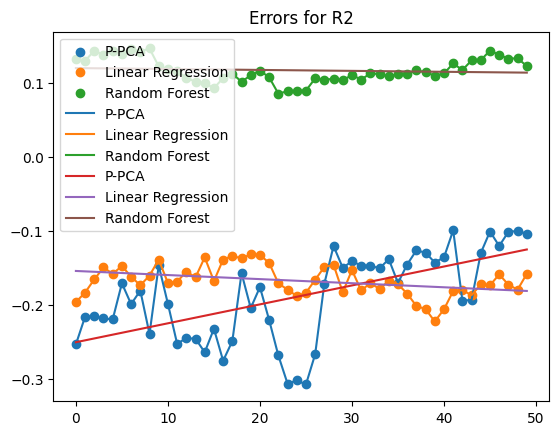

In [39]:
# Specific range
start, end = 0, 30

print(error_PPCA.shape)
x_plot = np.arange(start, end)

# scatter
plt.scatter(x_plot, error_PPCA[:len(x_plot)], label = 'P-PCA')
plt.scatter(x_plot, error_linreg[:len(x_plot)], label = 'Linear Regression')
plt.scatter(x_plot, error_rfr[:len(x_plot)], label = 'Random Forest')

# linear
plt.plot(x_plot, error_PPCA[:len(x_plot)], label = 'P-PCA')
plt.plot(x_plot, error_linreg[:len(x_plot)], label = 'Linear Regression')
plt.plot(x_plot, error_rfr[:len(x_plot)], label = 'Random Forest')

# best line fit
a, b = np.polyfit(x_plot, error_PPCA[:len(x_plot)], 1)
plt.plot(x_plot, a*x_plot+b, label = "P-PCA")

a, b = np.polyfit(x_plot, error_linreg[:len(x_plot)], 1)
plt.plot(x_plot, a*x_plot+b, label = "Linear Regression")

a, b = np.polyfit(x_plot, error_rfr[:len(x_plot)], 1)
plt.plot(x_plot, a*x_plot+b, label = "Random Forest")

plt.title(f'Errors for {metric_name}')
plt.legend()

0.0031328672408748688